In [1]:
import tensorflow as tf
import tensorflow.keras as keras
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Flatten, Reshape
from keras.datasets import mnist
from keras.optimizers import Adam,SGD
from keras.initializers import RandomNormal
from keras import losses
import numpy as np
import matplotlib.pyplot as plt
import keras.backend as K
import random

C:\Users\sudha\python3.6\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
initializer = RandomNormal(mean=0.0, stddev=0.01, seed=None)
#initializing the parameters for model training 
#epochs =6000 for 4 class training
epochs=4000
e_h_1=1000
e_h_2=1000
encoded_dim=8
d_h_1=1000
d_h_2=1000
#disc_h_1=1000
#disc_h_2=1000
img_shape=(28,28,1)
optimizer_reconst=Adam(0.00005)
#optimizer_discriminator=Adam(0.00008)
#optimizer_encoder_discriminator=Adam(0.00006)
#lr=0.0037 ideal lr Very Important On my machine

# Preparing the DataSet 

In [3]:

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train=x_train.reshape(x_train.shape[0],28,28,1).astype(np.float32)
x_train = x_train.astype(np.float32) / 255.
x_test=x_test.reshape(x_test.shape[0],28,28,1).astype(np.float32)
x_test = x_test.astype(np.float32) / 255.

In [4]:
data_train=dict()
data_train_label=dict()
data_test=dict()
data_test_label=dict()

for i in range(10):
    data_train[str(i)]=[]
    data_train_label[str(i)]=[]
    data_test[str(i)]=[]
    data_test_label[str(i)]=[]
for i in range(y_train.shape[0]):
    val=y_train[i]
    data_train[str(val)].append(x_train[i])
    data_train_label[str(val)].append(y_train[i])
for i in range(y_test.shape[0]):
    val=y_test[i]
    data_test[str(val)].append(x_test[i])
    data_test_label[str(val)].append(y_test[i])


In [6]:
def prep(kno,unk):
    known_train=list()
    known_train_labels=list()
    unknown_train=list()
    unknown_train_labels=list()
    known_test=list()
    known_test_labels=list()
    unknown_test=list()
    unknown_test_labels=list()
    for i in kno:
        known_train=known_train+data_train[str(i)]
        known_train_labels=known_train_labels+data_train_label[str(i)]
        known_test=known_test+data_test[str(i)]
        known_test_labels=known_test_labels+data_test_label[str(i)]
    for i in unk:
        unknown_train=unknown_train+data_train[str(i)]
        unknown_train_labels=unknown_train_labels+data_train_label[str(i)]
        unknown_test=unknown_test+data_test[str(i)]
        unknown_test_labels=unknown_test_labels+data_test_label[str(i)]
    
    shl=list(zip(known_train,known_train_labels))
    random.shuffle(shl)
    known_train,known_train_labels=zip(*shl)
    
    shl=list(zip(known_test,known_test_labels))
    random.shuffle(shl)
    known_test,known_test_labels=zip(*shl)
    
    shl=list(zip(unknown_train,unknown_train_labels))
    random.shuffle(shl)
    unknown_train,unknown_train_labels=zip(*shl)
    
    shl=list(zip(unknown_test,unknown_test_labels))
    random.shuffle(shl)
    unknown_test,unknown_test_labels=zip(*shl)
    
    known_train=np.array(known_train)
    known_train_labels=np.array(known_train_labels)
    unknown_train=np.array(unknown_train)
    unknown_train_labels=np.array(unknown_train_labels)
    known_test=np.array(known_test)
    known_test_labels=np.array(known_test_labels)
    unknown_test=np.array(unknown_test)
    unknown_test_labels=np.array(unknown_test_labels)
    return known_train,known_train_labels,known_test,known_test_labels,unknown_train,unknown_train_labels,unknown_test,unknown_test_labels



In [5]:
#Error function for calculating reconstruction error for each data
def err(a,b):
    a=np.array(a,dtype=np.float32)
    size=np.shape(a)
    err=a-b
    mse=err*err
    l=np.shape(size)
    l=l[0]
    for _ in range(l):
        mse=np.sum(mse)
    mse=mse/np.prod(size)
    return mse

In [12]:
#for i in range(9,10):
#Input the values in kno and unk according to the unknown classes
kno=[8,9]
unk=[0,1,2,3,4,5,6,7]
del unk[i-1]
known_train,known_train_labels,known_test,known_test_labels,unknown_train,unknown_train_labels,unknown_test,unknown_test_labels=prep(kno,unk)

# Defining The Model

##Encoder model

x_input=Input(img_shape)
flatten_layer=Flatten(input_shape=img_shape)(x_input)
encoder_hidden_1=Dense(e_h_1,activation='relu',kernel_initializer=initializer,
                       bias_initializer=initializer)(flatten_layer)
encoder_hidden_2=Dense(e_h_2,activation='relu',kernel_initializer=initializer,
                       bias_initializer=initializer)(encoder_hidden_1)
z_code=Dense(encoded_dim,activation='linear',kernel_initializer=initializer,
                       bias_initializer=initializer)(encoder_hidden_2)
encoder=Model(inputs=x_input,outputs=z_code)



##Decoder model


d_x_input=Input((encoded_dim,))
decoder_hidden_1=Dense(d_h_1,activation='relu',kernel_initializer=initializer,
                       bias_initializer=initializer)(d_x_input)
decoder_hidden_2=Dense(d_h_2,activation='relu',kernel_initializer=initializer,
                       bias_initializer=initializer)(decoder_hidden_1)
decoder_image=Dense(np.prod(img_shape),activation='sigmoid',kernel_initializer=initializer,
                       bias_initializer=initializer)(decoder_hidden_2)
gen_img=Reshape(img_shape)(decoder_image)

decoder=Model(inputs=d_x_input,outputs=gen_img)

##AutoEncoder

img=Input(shape=img_shape)
encoded_repr=encoder(img)
recons_img=decoder(encoded_repr)
AutoEncoder=Model(inputs=img,outputs=recons_img)




AutoEncoder.compile(optimizer=optimizer_reconst,
                    loss='mse',metrics=['mse'])



# Training the Model

##Training
batch_size=200
#d_err=[]
recons=[]
#g_e_err=[]

for epoch in range(epochs):
    half_batch=int(batch_size/2)
    idx = np.random.randint(0, known_train.shape[0], half_batch)
    imgs=known_train[idx]
    #latent_fake=encoder.predict(imgs)
    #latent_real= np.random.normal(size=(half_batch, encoded_dim))
    #valid =0.9*np.ones((half_batch, 1))
    #fake = np.zeros((half_batch, 1))
    #d_loss_real = discriminator.train_on_batch(latent_real, valid)
    #d_loss_fake = discriminator.train_on_batch(latent_fake, fake)
    #d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    #d_err.append(d_loss)
    #idx = np.random.randint(0, x_train.shape[0], batch_size)
    #imgs = x_train[idx]
    #valid_y = 0.9*np.ones((half_batch, 1))
    g_loss_reconstruction = AutoEncoder.train_on_batch(imgs, imgs)
    recons.append(g_loss_reconstruction)
    #for i in range(5):
    #g_loss_similarity = Encoder_Discriminator.train_on_batch(imgs, valid_y)
    #g_e_err.append(g_loss_similarity)
    #print(g_loss_similarity)
    #print(g_loss_reconstruction)
    #quit()
    AutoEncoder.save_weights('AE_AE_weights.h5')
    #discriminator.save_weights('AAE_Disc_weights.h5')
    #Encoder_Discriminator.save_weights('AAE_ED_weights.h5')
    print ("%d :  mse: %f]" % (epoch,g_loss_reconstruction[1]))
    #print ("%d [ mse: %f]" % (epoch, g_loss_reconstruction[1]))
#AutoEncoder.fit(x=x_train,y=x_train, epochs=15)
AutoEncoder.save_weights("Known"+str(kno)+"_AE_AE_weights.h5")
#discriminator.save_weights("Known"+str(kno)+"_AAE_Disc_weights.h5")
#Encoder_Discriminator.save_weights("Known"+str(kno)+"_AAE_ED_weights.h5")


#AutoEncoder.save_weights('AAE_AE_weights.h5')
#discriminator.save_weights('AAE_Disc_weights.h5')
#Encoder_Discriminator.save_weights('AAE_ED_weights.h5')


#Saving The errors

train_error_kn=[]
test_error_kn=[]
test_error_unk=[]
test_error_per=dict()
train_error_per=dict()
for i in range(10):
    test_error_per[str(i)]=[]
    train_error_per[str(i)]=[]
for i in range(known_train.shape[0]):
    img=known_train[i].reshape(1,28,28,1)
    error,_=AutoEncoder.evaluate(img,img)
    idx=known_train_labels[i]
    train_error_per[str(idx)].append(error)
    train_error_kn.append(error)
for i in range(known_test.shape[0]):
    img=known_test[i].reshape(1,28,28,1)
    error,_=AutoEncoder.evaluate(img,img)
    idx=known_test_labels[i]
    encd=encoder.predict(img)
    test_error_per[str(idx)].append(error)
    test_error_kn.append(error)
for i in range(unknown_train_labels.shape[0]):
    idx=unknown_train_labels[i]
    img=unknown_train[i].reshape(1,28,28,1)
    error,_=AutoEncoder.evaluate(img,img)
    test_error_per[str(idx)].append(error)
    test_error_unk.append(error)
for i in range(unknown_test_labels.shape[0]):
    img=unknown_test[i].reshape(1,28,28,1)
    idx=unknown_test_labels[i]
    error=AutoEncoder.evaluate(img,img)
    test_error_per[str(idx)].append(error)
    test_error_unk.append(error)


#Saving The Errors To A File

file=open("KnownAE"+str(kno)+"train_error_kn.txt","w")
for error in train_error_kn:
    file.write(str(error)+" ")
file.close()

file=open("KnownAE"+str(kno)+"test_error_kn.txt","w")
for error in test_error_kn:
    file.write(str(error)+" ")
file.close()
file=open("KnownAE"+str(kno)+"test_error_unk.txt","w")
for error in test_error_unk:
    file.write(str(error)+" ")
file.close()

file=open("KnownAE"+str(kno)+"recons.txt","w")
for error in recons:
    file.write(str(error)+" ")
file.close()
np.save("KnownAE"+str(kno)+"test_error_per.npy",test_error_per)
np.save("KnownAE"+str(kno)+"train_error_per.npy",train_error_per)


0 :  mse: 0.230035]
1 :  mse: 0.230188]
2 :  mse: 0.229445]
3 :  mse: 0.229411]
4 :  mse: 0.229019]
5 :  mse: 0.229140]
6 :  mse: 0.228741]
7 :  mse: 0.228827]
8 :  mse: 0.227869]
9 :  mse: 0.227819]
10 :  mse: 0.226839]
11 :  mse: 0.226659]
12 :  mse: 0.225598]
13 :  mse: 0.224757]
14 :  mse: 0.224389]
15 :  mse: 0.222481]
16 :  mse: 0.221708]
17 :  mse: 0.220321]
18 :  mse: 0.219242]
19 :  mse: 0.217319]
20 :  mse: 0.215200]
21 :  mse: 0.213078]
22 :  mse: 0.209907]
23 :  mse: 0.206521]
24 :  mse: 0.201714]
25 :  mse: 0.194073]
26 :  mse: 0.184067]
27 :  mse: 0.171393]
28 :  mse: 0.154830]
29 :  mse: 0.134374]
30 :  mse: 0.110785]
31 :  mse: 0.091960]
32 :  mse: 0.073536]
33 :  mse: 0.068810]
34 :  mse: 0.079231]
35 :  mse: 0.075792]
36 :  mse: 0.076649]
37 :  mse: 0.071293]
38 :  mse: 0.076930]
39 :  mse: 0.076271]
40 :  mse: 0.077402]
41 :  mse: 0.074597]
42 :  mse: 0.075161]
43 :  mse: 0.073607]
44 :  mse: 0.075046]
45 :  mse: 0.069908]
46 :  mse: 0.073547]
47 :  mse: 0.071678]
48

382 :  mse: 0.056236]
383 :  mse: 0.055113]
384 :  mse: 0.058133]
385 :  mse: 0.057853]
386 :  mse: 0.056021]
387 :  mse: 0.053221]
388 :  mse: 0.055518]
389 :  mse: 0.056465]
390 :  mse: 0.054740]
391 :  mse: 0.053877]
392 :  mse: 0.056212]
393 :  mse: 0.057284]
394 :  mse: 0.059813]
395 :  mse: 0.055476]
396 :  mse: 0.057255]
397 :  mse: 0.056736]
398 :  mse: 0.054086]
399 :  mse: 0.055059]
400 :  mse: 0.054704]
401 :  mse: 0.055314]
402 :  mse: 0.053633]
403 :  mse: 0.056516]
404 :  mse: 0.056561]
405 :  mse: 0.054164]
406 :  mse: 0.056846]
407 :  mse: 0.058566]
408 :  mse: 0.058274]
409 :  mse: 0.055739]
410 :  mse: 0.056764]
411 :  mse: 0.054079]
412 :  mse: 0.057722]
413 :  mse: 0.056779]
414 :  mse: 0.055151]
415 :  mse: 0.055660]
416 :  mse: 0.057203]
417 :  mse: 0.055140]
418 :  mse: 0.056018]
419 :  mse: 0.054985]
420 :  mse: 0.053841]
421 :  mse: 0.053430]
422 :  mse: 0.057903]
423 :  mse: 0.054015]
424 :  mse: 0.057774]
425 :  mse: 0.056423]
426 :  mse: 0.055910]
427 :  mse

762 :  mse: 0.052706]
763 :  mse: 0.054248]
764 :  mse: 0.055998]
765 :  mse: 0.052532]
766 :  mse: 0.055947]
767 :  mse: 0.053725]
768 :  mse: 0.053749]
769 :  mse: 0.053296]
770 :  mse: 0.056730]
771 :  mse: 0.055046]
772 :  mse: 0.054731]
773 :  mse: 0.054496]
774 :  mse: 0.052742]
775 :  mse: 0.054552]
776 :  mse: 0.056580]
777 :  mse: 0.054700]
778 :  mse: 0.052986]
779 :  mse: 0.057286]
780 :  mse: 0.051090]
781 :  mse: 0.055132]
782 :  mse: 0.051948]
783 :  mse: 0.054022]
784 :  mse: 0.052872]
785 :  mse: 0.054191]
786 :  mse: 0.054020]
787 :  mse: 0.053161]
788 :  mse: 0.052235]
789 :  mse: 0.055995]
790 :  mse: 0.052255]
791 :  mse: 0.055349]
792 :  mse: 0.053141]
793 :  mse: 0.055035]
794 :  mse: 0.053050]
795 :  mse: 0.054015]
796 :  mse: 0.054023]
797 :  mse: 0.054799]
798 :  mse: 0.055649]
799 :  mse: 0.055008]
800 :  mse: 0.052480]
801 :  mse: 0.053269]
802 :  mse: 0.052429]
803 :  mse: 0.053024]
804 :  mse: 0.058232]
805 :  mse: 0.055308]
806 :  mse: 0.053846]
807 :  mse

1129 :  mse: 0.049832]
1130 :  mse: 0.051661]
1131 :  mse: 0.050056]
1132 :  mse: 0.049377]
1133 :  mse: 0.047180]
1134 :  mse: 0.049102]
1135 :  mse: 0.047280]
1136 :  mse: 0.048286]
1137 :  mse: 0.049833]
1138 :  mse: 0.048252]
1139 :  mse: 0.051007]
1140 :  mse: 0.048754]
1141 :  mse: 0.049156]
1142 :  mse: 0.049840]
1143 :  mse: 0.048573]
1144 :  mse: 0.050432]
1145 :  mse: 0.045410]
1146 :  mse: 0.046595]
1147 :  mse: 0.050072]
1148 :  mse: 0.049206]
1149 :  mse: 0.046741]
1150 :  mse: 0.050111]
1151 :  mse: 0.048532]
1152 :  mse: 0.048587]
1153 :  mse: 0.047387]
1154 :  mse: 0.046834]
1155 :  mse: 0.050490]
1156 :  mse: 0.049622]
1157 :  mse: 0.048390]
1158 :  mse: 0.049882]
1159 :  mse: 0.045649]
1160 :  mse: 0.049691]
1161 :  mse: 0.049733]
1162 :  mse: 0.049865]
1163 :  mse: 0.048252]
1164 :  mse: 0.053016]
1165 :  mse: 0.050443]
1166 :  mse: 0.047490]
1167 :  mse: 0.049142]
1168 :  mse: 0.048888]
1169 :  mse: 0.049606]
1170 :  mse: 0.050022]
1171 :  mse: 0.046401]
1172 :  mse

1492 :  mse: 0.043792]
1493 :  mse: 0.043331]
1494 :  mse: 0.039744]
1495 :  mse: 0.040905]
1496 :  mse: 0.041287]
1497 :  mse: 0.044267]
1498 :  mse: 0.043513]
1499 :  mse: 0.041908]
1500 :  mse: 0.044377]
1501 :  mse: 0.040738]
1502 :  mse: 0.042770]
1503 :  mse: 0.041941]
1504 :  mse: 0.043925]
1505 :  mse: 0.040455]
1506 :  mse: 0.042546]
1507 :  mse: 0.041242]
1508 :  mse: 0.042615]
1509 :  mse: 0.042444]
1510 :  mse: 0.045146]
1511 :  mse: 0.042109]
1512 :  mse: 0.043863]
1513 :  mse: 0.040659]
1514 :  mse: 0.039684]
1515 :  mse: 0.041677]
1516 :  mse: 0.039494]
1517 :  mse: 0.038953]
1518 :  mse: 0.041886]
1519 :  mse: 0.043701]
1520 :  mse: 0.044560]
1521 :  mse: 0.043278]
1522 :  mse: 0.042959]
1523 :  mse: 0.043248]
1524 :  mse: 0.042539]
1525 :  mse: 0.040707]
1526 :  mse: 0.041662]
1527 :  mse: 0.042210]
1528 :  mse: 0.040751]
1529 :  mse: 0.040914]
1530 :  mse: 0.043222]
1531 :  mse: 0.041016]
1532 :  mse: 0.039331]
1533 :  mse: 0.041466]
1534 :  mse: 0.040288]
1535 :  mse

1854 :  mse: 0.036501]
1855 :  mse: 0.038271]
1856 :  mse: 0.040207]
1857 :  mse: 0.037587]
1858 :  mse: 0.037041]
1859 :  mse: 0.038185]
1860 :  mse: 0.035470]
1861 :  mse: 0.037796]
1862 :  mse: 0.036691]
1863 :  mse: 0.038313]
1864 :  mse: 0.039217]
1865 :  mse: 0.035094]
1866 :  mse: 0.035364]
1867 :  mse: 0.035641]
1868 :  mse: 0.037258]
1869 :  mse: 0.035542]
1870 :  mse: 0.035828]
1871 :  mse: 0.036450]
1872 :  mse: 0.036616]
1873 :  mse: 0.035620]
1874 :  mse: 0.037400]
1875 :  mse: 0.034729]
1876 :  mse: 0.034366]
1877 :  mse: 0.036937]
1878 :  mse: 0.035552]
1879 :  mse: 0.036624]
1880 :  mse: 0.037016]
1881 :  mse: 0.036488]
1882 :  mse: 0.035433]
1883 :  mse: 0.035896]
1884 :  mse: 0.036196]
1885 :  mse: 0.037535]
1886 :  mse: 0.037345]
1887 :  mse: 0.036663]
1888 :  mse: 0.039178]
1889 :  mse: 0.036155]
1890 :  mse: 0.037950]
1891 :  mse: 0.036232]
1892 :  mse: 0.038236]
1893 :  mse: 0.036696]
1894 :  mse: 0.033043]
1895 :  mse: 0.035117]
1896 :  mse: 0.036749]
1897 :  mse

2216 :  mse: 0.035151]
2217 :  mse: 0.031547]
2218 :  mse: 0.034084]
2219 :  mse: 0.035057]
2220 :  mse: 0.032713]
2221 :  mse: 0.035256]
2222 :  mse: 0.032064]
2223 :  mse: 0.034201]
2224 :  mse: 0.035602]
2225 :  mse: 0.034234]
2226 :  mse: 0.031724]
2227 :  mse: 0.032642]
2228 :  mse: 0.034524]
2229 :  mse: 0.036114]
2230 :  mse: 0.032742]
2231 :  mse: 0.035351]
2232 :  mse: 0.033386]
2233 :  mse: 0.032383]
2234 :  mse: 0.032806]
2235 :  mse: 0.034184]
2236 :  mse: 0.035366]
2237 :  mse: 0.031180]
2238 :  mse: 0.031735]
2239 :  mse: 0.032815]
2240 :  mse: 0.036689]
2241 :  mse: 0.031983]
2242 :  mse: 0.032518]
2243 :  mse: 0.033317]
2244 :  mse: 0.031557]
2245 :  mse: 0.032294]
2246 :  mse: 0.033160]
2247 :  mse: 0.033652]
2248 :  mse: 0.033150]
2249 :  mse: 0.033974]
2250 :  mse: 0.033952]
2251 :  mse: 0.033755]
2252 :  mse: 0.034361]
2253 :  mse: 0.034674]
2254 :  mse: 0.033781]
2255 :  mse: 0.032854]
2256 :  mse: 0.032852]
2257 :  mse: 0.031625]
2258 :  mse: 0.032753]
2259 :  mse

2573 :  mse: 0.034642]
2574 :  mse: 0.030104]
2575 :  mse: 0.030894]
2576 :  mse: 0.030876]
2577 :  mse: 0.031169]
2578 :  mse: 0.029710]
2579 :  mse: 0.030318]
2580 :  mse: 0.030316]
2581 :  mse: 0.030161]
2582 :  mse: 0.032835]
2583 :  mse: 0.032498]
2584 :  mse: 0.031712]
2585 :  mse: 0.027789]
2586 :  mse: 0.030601]
2587 :  mse: 0.031079]
2588 :  mse: 0.034320]
2589 :  mse: 0.027506]
2590 :  mse: 0.031477]
2591 :  mse: 0.028669]
2592 :  mse: 0.033099]
2593 :  mse: 0.030268]
2594 :  mse: 0.030304]
2595 :  mse: 0.031814]
2596 :  mse: 0.030908]
2597 :  mse: 0.030604]
2598 :  mse: 0.031651]
2599 :  mse: 0.031404]
2600 :  mse: 0.030679]
2601 :  mse: 0.031898]
2602 :  mse: 0.029925]
2603 :  mse: 0.032690]
2604 :  mse: 0.030987]
2605 :  mse: 0.032127]
2606 :  mse: 0.031043]
2607 :  mse: 0.029923]
2608 :  mse: 0.031028]
2609 :  mse: 0.031861]
2610 :  mse: 0.028130]
2611 :  mse: 0.031362]
2612 :  mse: 0.031511]
2613 :  mse: 0.030782]
2614 :  mse: 0.031308]
2615 :  mse: 0.028788]
2616 :  mse

2932 :  mse: 0.032015]
2933 :  mse: 0.030086]
2934 :  mse: 0.029391]
2935 :  mse: 0.027623]
2936 :  mse: 0.029369]
2937 :  mse: 0.029943]
2938 :  mse: 0.028170]
2939 :  mse: 0.029409]
2940 :  mse: 0.030276]
2941 :  mse: 0.027502]
2942 :  mse: 0.030148]
2943 :  mse: 0.031467]
2944 :  mse: 0.028574]
2945 :  mse: 0.030961]
2946 :  mse: 0.031156]
2947 :  mse: 0.028927]
2948 :  mse: 0.028325]
2949 :  mse: 0.028821]
2950 :  mse: 0.031807]
2951 :  mse: 0.030988]
2952 :  mse: 0.030672]
2953 :  mse: 0.032329]
2954 :  mse: 0.029584]
2955 :  mse: 0.031436]
2956 :  mse: 0.028487]
2957 :  mse: 0.029302]
2958 :  mse: 0.029274]
2959 :  mse: 0.029085]
2960 :  mse: 0.030100]
2961 :  mse: 0.027953]
2962 :  mse: 0.029925]
2963 :  mse: 0.029771]
2964 :  mse: 0.028136]
2965 :  mse: 0.028692]
2966 :  mse: 0.028898]
2967 :  mse: 0.029431]
2968 :  mse: 0.027737]
2969 :  mse: 0.029463]
2970 :  mse: 0.028151]
2971 :  mse: 0.030449]
2972 :  mse: 0.029319]
2973 :  mse: 0.030770]
2974 :  mse: 0.027025]
2975 :  mse

3296 :  mse: 0.028632]
3297 :  mse: 0.028273]
3298 :  mse: 0.028188]
3299 :  mse: 0.028386]
3300 :  mse: 0.027013]
3301 :  mse: 0.027651]
3302 :  mse: 0.029870]
3303 :  mse: 0.025676]
3304 :  mse: 0.029814]
3305 :  mse: 0.028116]
3306 :  mse: 0.027672]
3307 :  mse: 0.027432]
3308 :  mse: 0.026913]
3309 :  mse: 0.026391]
3310 :  mse: 0.028094]
3311 :  mse: 0.026218]
3312 :  mse: 0.027584]
3313 :  mse: 0.028000]
3314 :  mse: 0.029426]
3315 :  mse: 0.029812]
3316 :  mse: 0.027518]
3317 :  mse: 0.026793]
3318 :  mse: 0.029354]
3319 :  mse: 0.028941]
3320 :  mse: 0.029452]
3321 :  mse: 0.026076]
3322 :  mse: 0.026435]
3323 :  mse: 0.030175]
3324 :  mse: 0.027751]
3325 :  mse: 0.031594]
3326 :  mse: 0.026442]
3327 :  mse: 0.029390]
3328 :  mse: 0.028169]
3329 :  mse: 0.028708]
3330 :  mse: 0.028337]
3331 :  mse: 0.028099]
3332 :  mse: 0.026110]
3333 :  mse: 0.029994]
3334 :  mse: 0.027632]
3335 :  mse: 0.025658]
3336 :  mse: 0.028421]
3337 :  mse: 0.028627]
3338 :  mse: 0.029803]
3339 :  mse

3659 :  mse: 0.027799]
3660 :  mse: 0.026243]
3661 :  mse: 0.027267]
3662 :  mse: 0.028680]
3663 :  mse: 0.028259]
3664 :  mse: 0.026714]
3665 :  mse: 0.028002]
3666 :  mse: 0.026706]
3667 :  mse: 0.025901]
3668 :  mse: 0.025663]
3669 :  mse: 0.028102]
3670 :  mse: 0.026216]
3671 :  mse: 0.026363]
3672 :  mse: 0.025822]
3673 :  mse: 0.026765]
3674 :  mse: 0.026132]
3675 :  mse: 0.025630]
3676 :  mse: 0.028158]
3677 :  mse: 0.025948]
3678 :  mse: 0.026943]
3679 :  mse: 0.027130]
3680 :  mse: 0.026468]
3681 :  mse: 0.025386]
3682 :  mse: 0.027184]
3683 :  mse: 0.027283]
3684 :  mse: 0.026444]
3685 :  mse: 0.027760]
3686 :  mse: 0.028280]
3687 :  mse: 0.025454]
3688 :  mse: 0.027129]
3689 :  mse: 0.027105]
3690 :  mse: 0.029037]
3691 :  mse: 0.028173]
3692 :  mse: 0.027229]
3693 :  mse: 0.027720]
3694 :  mse: 0.025477]
3695 :  mse: 0.026617]
3696 :  mse: 0.025660]
3697 :  mse: 0.027891]
3698 :  mse: 0.028114]
3699 :  mse: 0.029259]
3700 :  mse: 0.025540]
3701 :  mse: 0.026901]
3702 :  mse

1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 4ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 4ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 4ms/step


1/1 [==============================] - 0s 4ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 4ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 4ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 5ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 5ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 4ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 4ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 4ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 4ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 4ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 4ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 4ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 4ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 4ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 4ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 4ms/step


1/1 [==============================] - 0s 5ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 4ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 4ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 4ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 4ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 4ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 4ms/step


1/1 [==============================] - 0s 4ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 5ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 3ms/step


100/100 [==============================] - 0s 160us/step


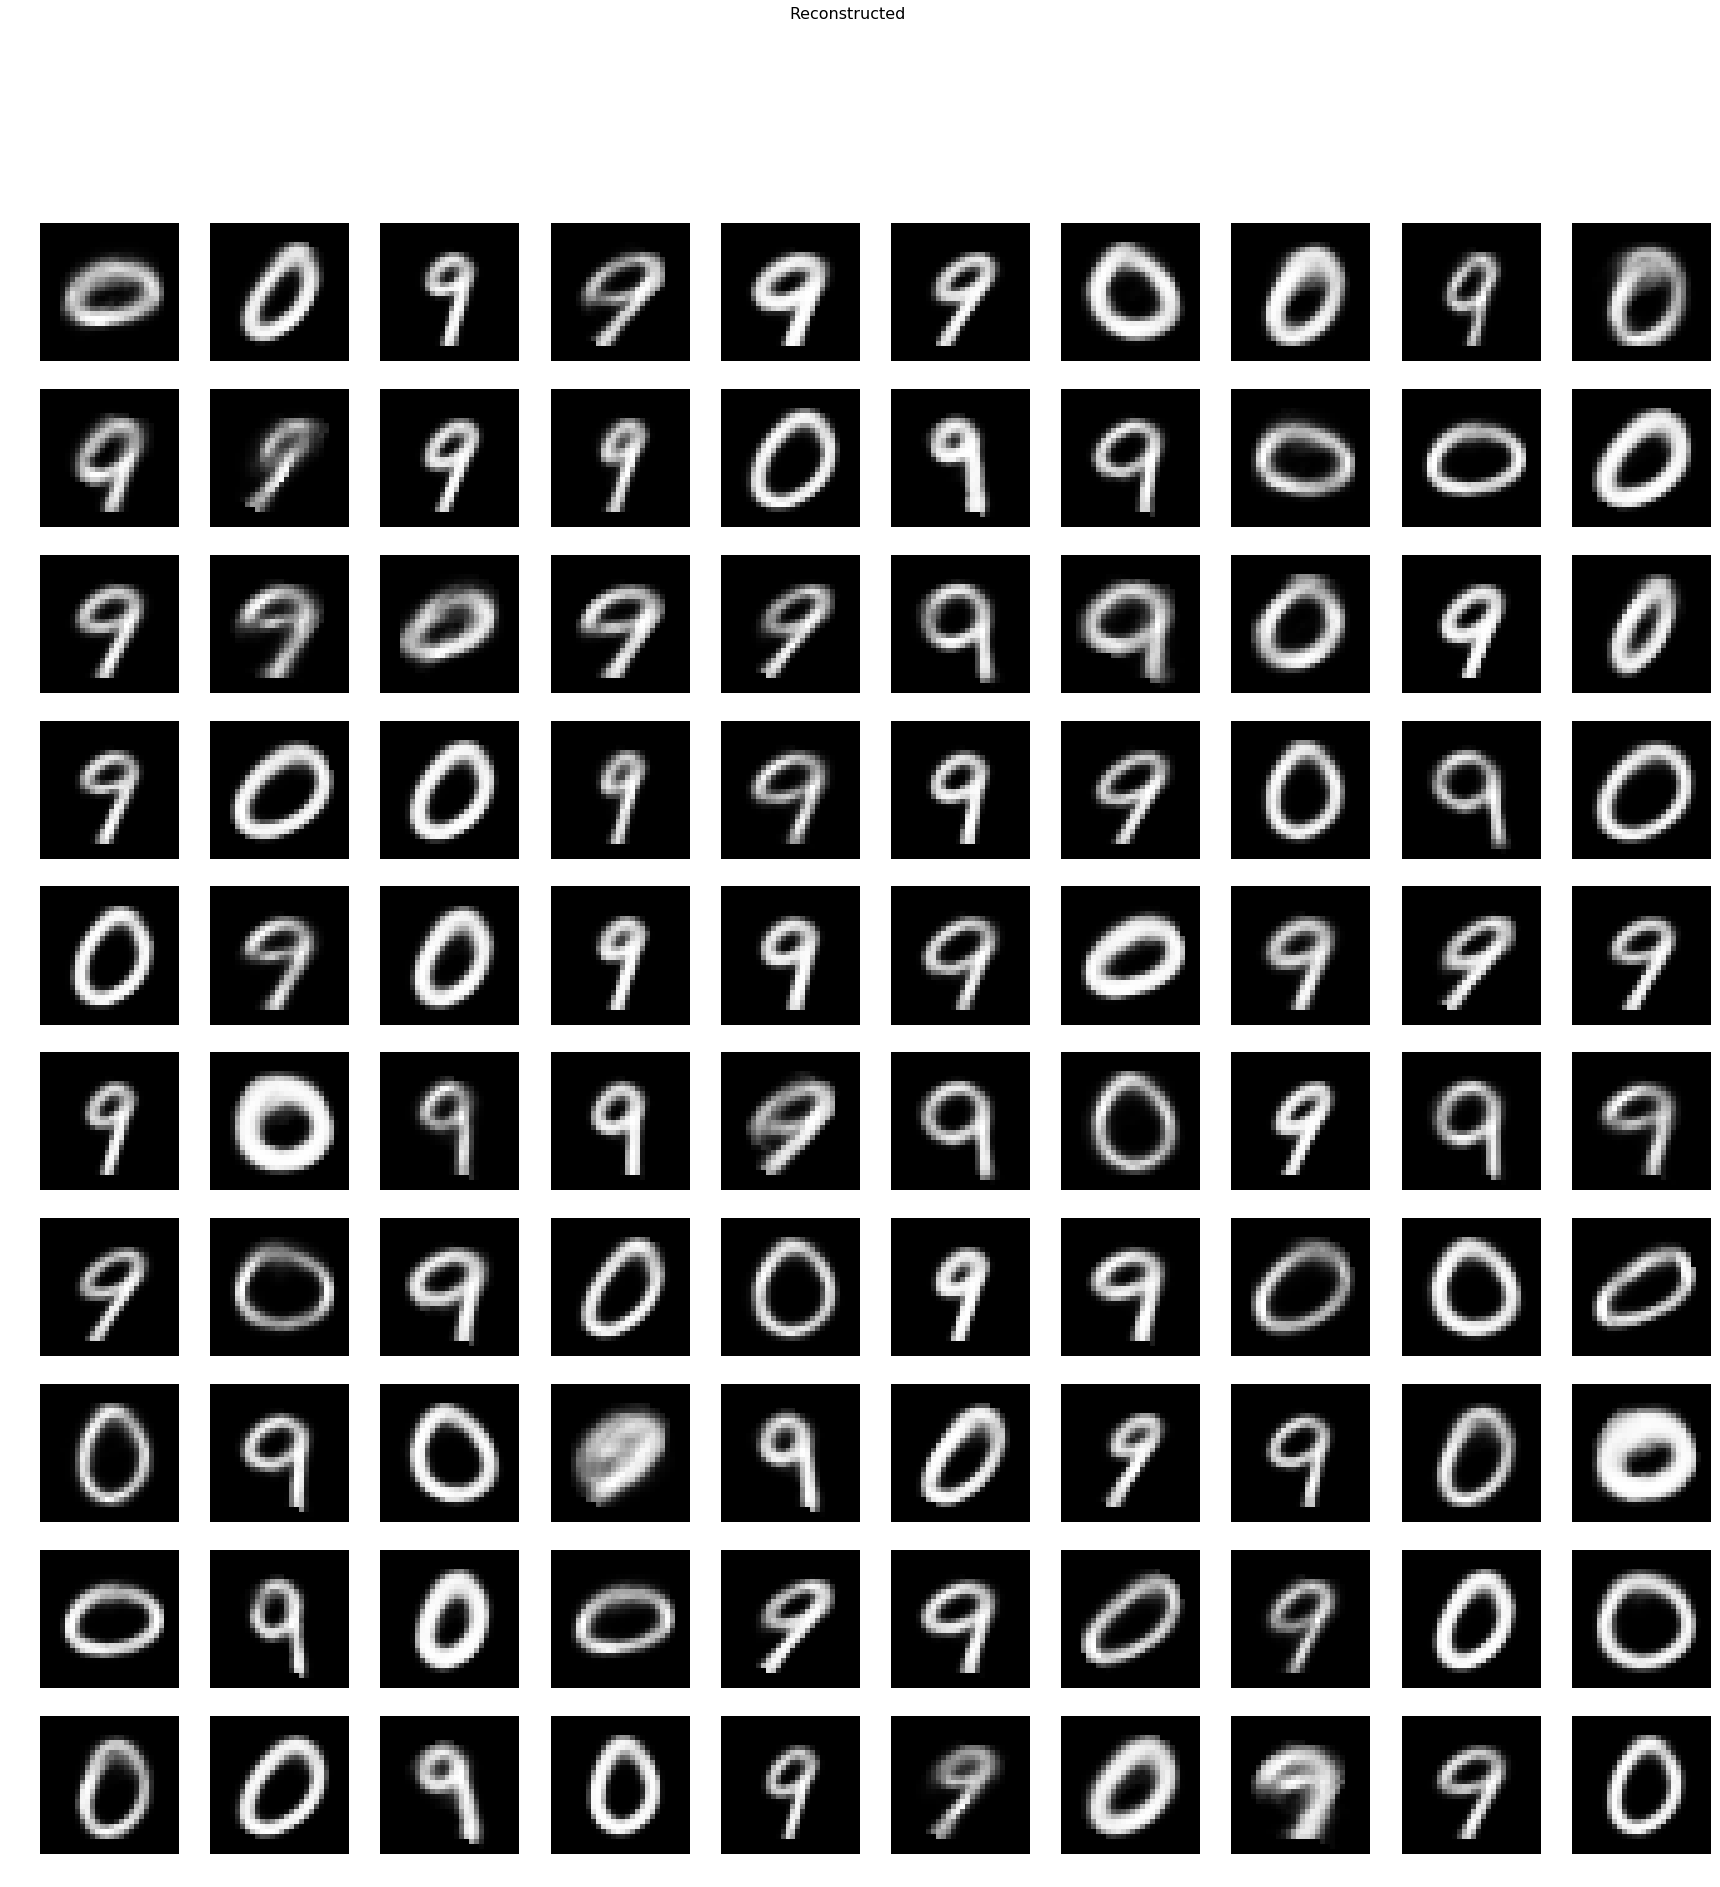

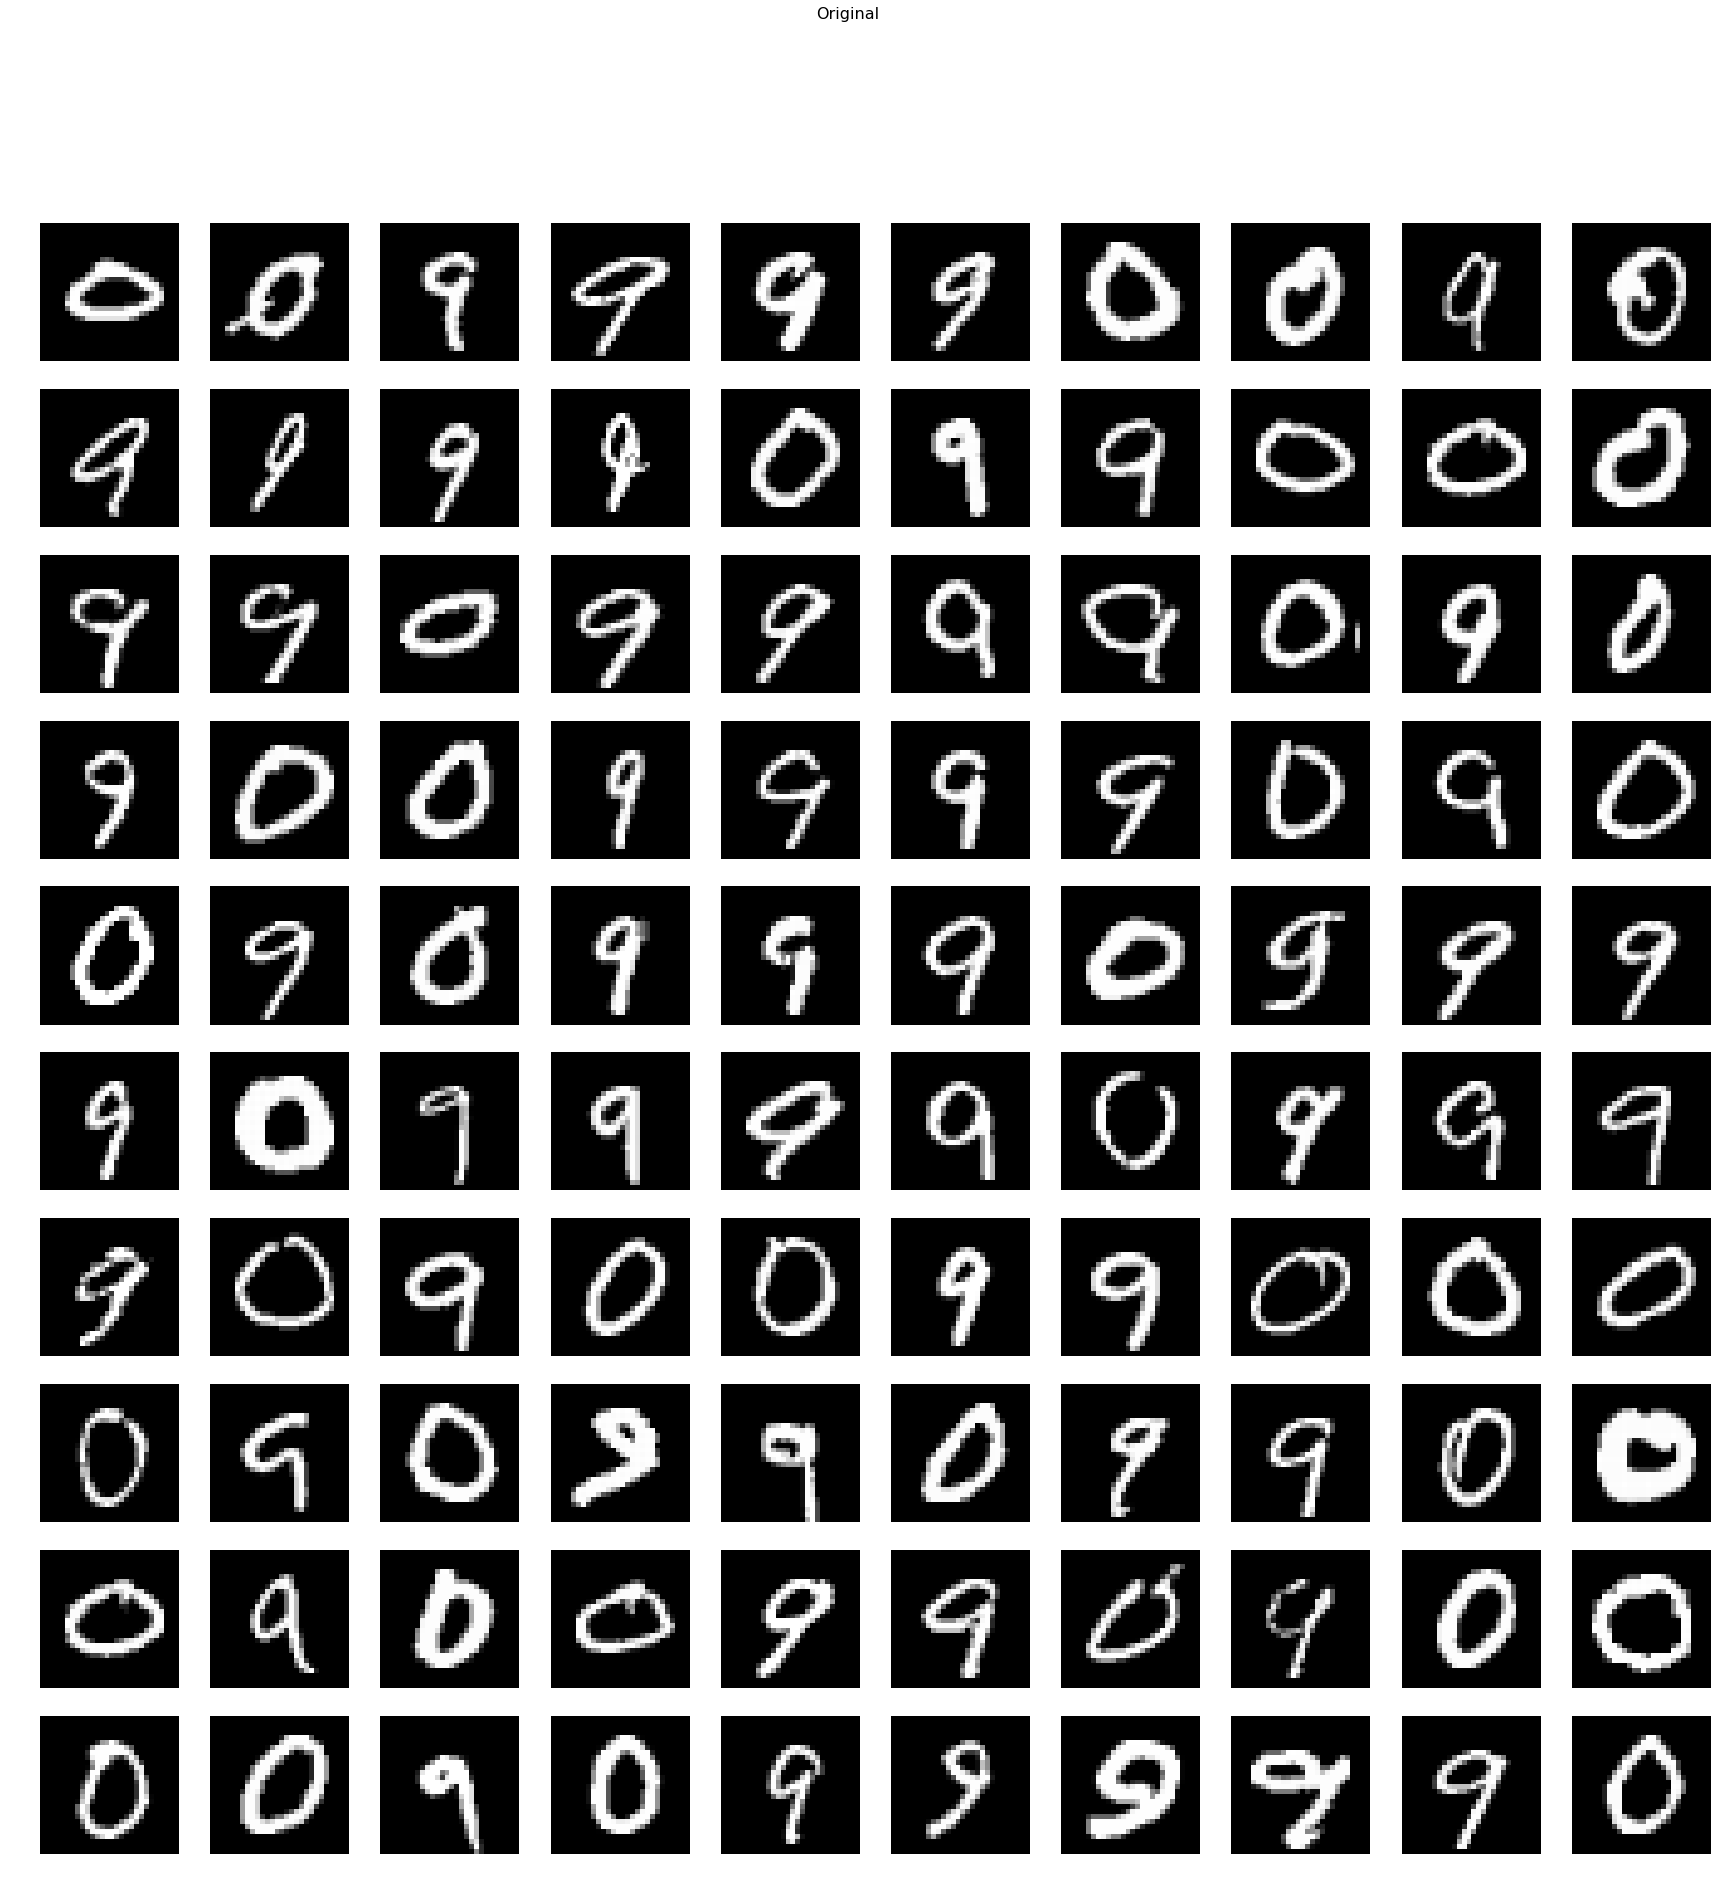

In [38]:
#Plotting the Images
fig=plt.figure(figsize=(30,30))
fig1=plt.figure(figsize=(30,30))
fig2=plt.figure(figsize=(30,30))
idx=np.random.randint(0,known_test.shape[0],100)
test_images=known_test[idx]
output_imgs=AutoEncoder.predict(test_images)
test_loss=AutoEncoder.evaluate(test_images,output_imgs)
output_imgs=output_imgs.reshape(output_imgs.shape[0],28,28)
test_images=test_images.reshape(test_images.shape[0],28,28)
fig.suptitle('Reconstructed',fontsize=16)
fig1.suptitle('Original',fontsize=16)
for index, image in enumerate(output_imgs):
    #img = img.reshape((28, 28))
    ax=fig.add_subplot(10,10,index+1)
    ax.set_axis_off()
    ax.imshow(image, cmap="gray")
for index, image in enumerate(test_images):
    #img = img.reshape((28, 28))
    ax=fig1.add_subplot(10,10,index+1)
    ax.set_axis_off()
    ax.imshow(image, cmap="gray")

plt.show()
plt.close(fig)
plt.close(fig1)


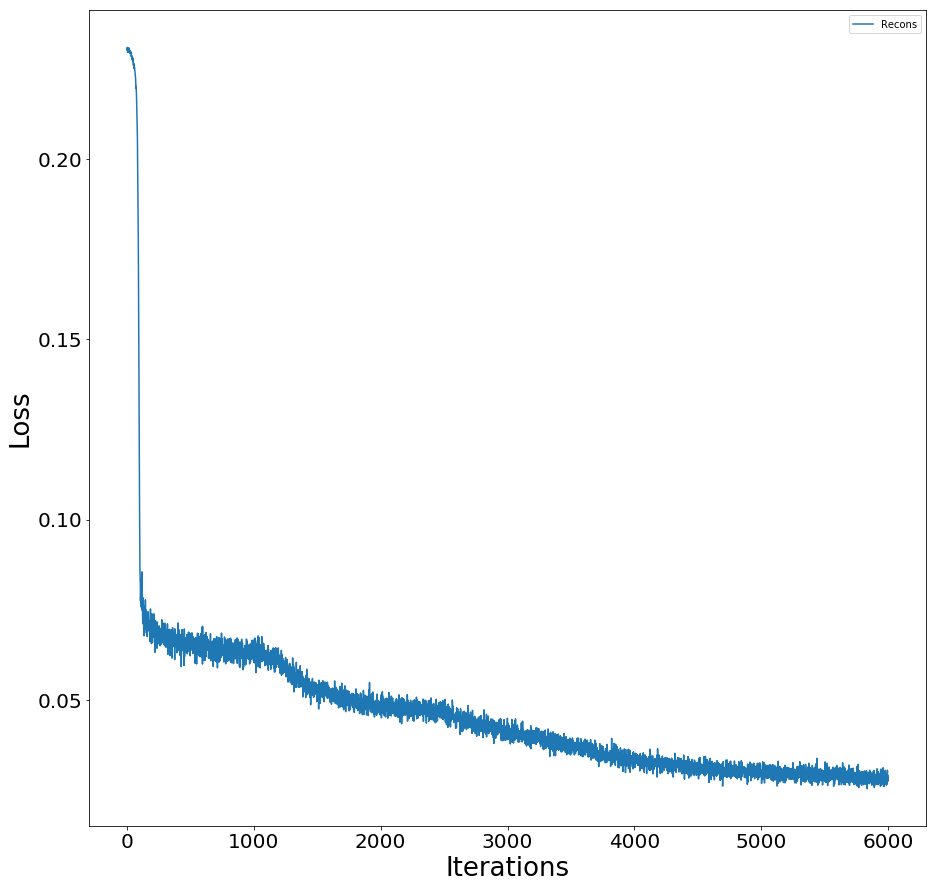

In [23]:

recons=np.array(recons)
plt.figure(figsize=(15,15))
fig.suptitle('Reconstruction Loss',fontsize=16)

plt.plot(recons[:,0],label='Recons')

plt.xlabel('Iterations',fontsize=26)
plt.ylabel('Loss',fontsize=26)
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)
plt.legend()
plt.show()